# pyBumpHunter : A model agnostic bump hunting tool in python

**presenter : Louis VASLIN  -  Université Clermont Auvergne (FR)**  
LPC/IN2P3

<img src="img/pyBH_logo.png" width="590" height="413"/>

[Link to github](https://github.com/scikit-hep/pyBumpHunter)  
[Link to PyPI](https://pypi.org/project/pyBumpHunter/)  
Based on [arXiv:1101.0390](https://arxiv.org/abs/1101.0390)

In [1]:
import numpy as np
import pyBumpHunter as BH
import matplotlib.pyplot as plt
from matplotlib import colors as mcl

## The BumpHunter algorithm

BumpHunter is a useful algorithm used in HEP community that allows to look for an **excess** (or deficit) in a **data** distribution w.r.t. a **reference background**.  
This "*bump hunt*" is done by scanning binned distributions (**histograms**).

<img src="img/BHscan.png" width="616" height="407"/>

It will compute the **local** and **global p-value** of the most significant **localized deviation** (bump) in the data.

### About local and global

The *local p-value* doesn't tell us how likely the observed deviation is to be a statistical fluctuation.  
To tell that, BumpHunter **generates toys** from the reference and scans them like normal data.

This will give a **background-only** local p-value distribution.

<img src="img/global.png" width="563" height="403"/>

The **global p-value** is then *the p-value of the local p-values*.  
t = -ln(local p-value)  <- BumpHunter test statistic

### Why pyBumpHunter ?

Public implementation based on pure python (numpy/scipy).  
Doesn't depend on the ROOT software.  
Recently integrated into Scikit-HEP.  
Still under active development.

### List of features

Currenly available features are :
* Scans of 1D and 2D distributions

* Signal injection tests (1D)

* Side-band normalization

## 1D scan

The basic scan that compares a data distribution to a reference background.  
It will give the position and width of the bump, as well as its local and global p-value.  
Also give a *rough* evaluation of the signal content of the bump (data - ref).

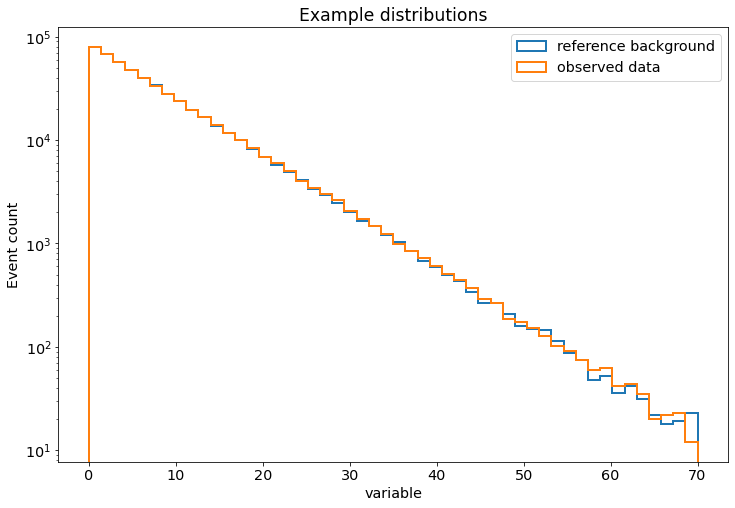

In [2]:
# Generate some background and data
np.random.seed(42)
bkg = np.random.exponential(scale=8.0, size=500_000)
data = np.random.exponential(scale=8.0, size=500_000)
data = np.append(
    data,
    np.random.normal(loc=20, scale=3, size=900)
)
rng = [0,70]

# Make histograms
bkg_hist, bins = np.histogram(bkg, bins=50, range=rng)
data_hist, _ = np.histogram(data, bins=bins)

# Plot the distributions
F = plt.figure(figsize=(12,8))
plt.title('Example distributions', size='xx-large')
plt.hist(bkg, bins=bins, histtype='step', lw=2, label='reference background')
plt.hist(data, bins=bins, histtype='step', lw=2, label='observed data')
plt.legend(fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.xlabel('variable',size='x-large')
plt.ylabel('Event count',size='x-large')
plt.yscale('log')
plt.show()

Generating histograms
5 values of width will be tested
SCAN
Global p-value : 0.0022  (22 / 10000)
Significance = 2.84796

##.print_bump_info() call##
BUMP WINDOW
   loc = 13
   width = 4
   local p-value | t = 0.00002 | 10.99941

##.print_bump_true() call##
BUMP POSITION
   min : 18.200
   max : 23.800
   mean : 21.000
   width : 5.600
   number of signal events : 668.0
   global p-value : 0.00220
   significance = 2.84796



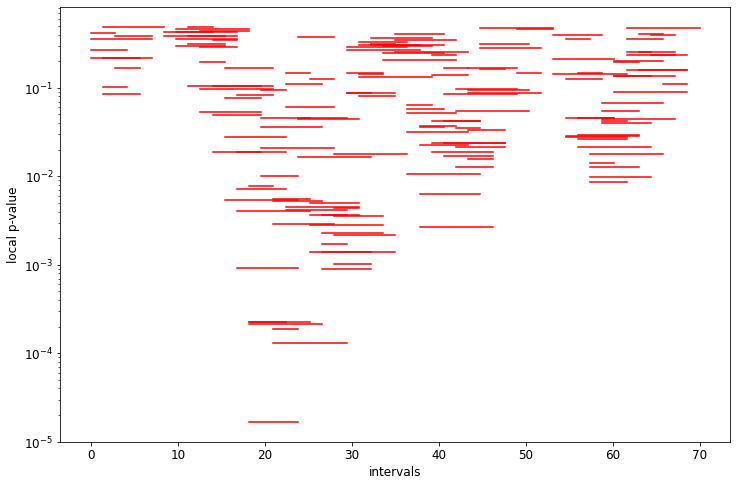

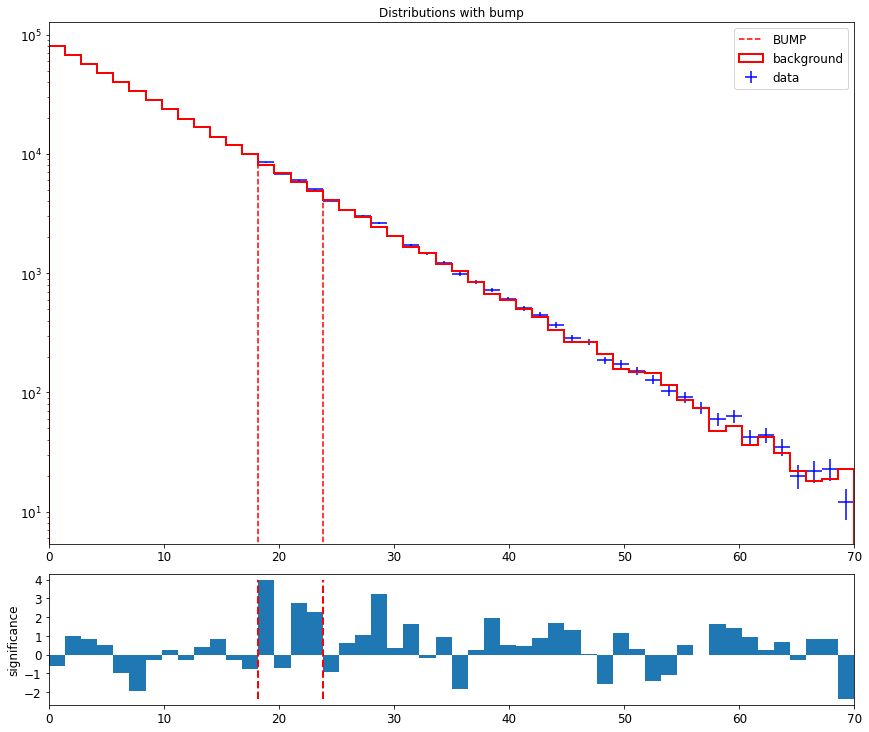

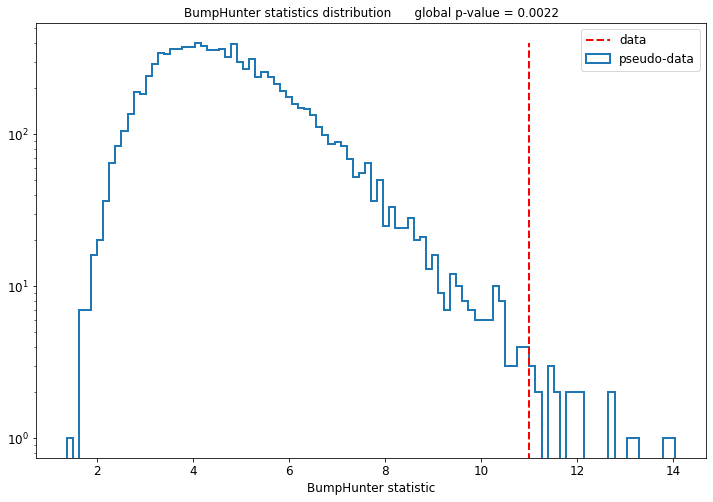

In [3]:
# Create a BumpHunter1D instance
bh1 = BH.BumpHunter1D(
    width_min=2,
    width_max=6,
    width_step=1,
    scan_step=1,
    bins=bins,
    rang=rng,
    npe=10_000,
    nworker=1,
    seed=666
)

# Call the scan method
# Here we give the data as non-histogramed distribution
bh1.bump_scan(data, bkg)

# Display results
print('##.print_bump_info() call##')
bh1.print_bump_info()
print('##.print_bump_true() call##')
bh1.print_bump_true(data, bkg)

bh1.plot_tomography(data)
bh1.plot_bump(data, bkg)
bh1.plot_stat(show_Pval=True)

## Signal injection

Add the possibility to perform signal injection tests using the BumpHunter algorithm to evaluate the sensibility to a given signal model.  
The injection is performed based on the reference background distribution and a signal distribution.  
The injection stops when the required sensitivity is reached (based on global significance).  
Currently, signal injection is only available in 1D.

In [4]:
# Generate some signal (normal distribution centered on 20)
sig = np.random.normal(loc=20, scale=3, size=10_000)
sig_hist, _  = np.histogram(sig, bins=bins)

Generating background only histograms
5 values of width will be tested
BACKGROUND ONLY SCAN
STARTING INJECTION
   STEP 1 : signal strength = 0.1
Generating background+signal histograms
BACKGROUND+SIGNAL SCAN
Global p-value : 0.0448  (448 / 10000)   0.0797  (797)   0.0141  (141)
Significance = 1.69751 (1.40709  2.19449)

   STEP 2 : signal strength = 0.2
Generating background+signal histograms
BACKGROUND+SIGNAL SCAN
Global p-value : 0.0397  (397 / 10000)   0.0751  (751)   0.0109  (109)
Significance = 1.75418 (1.43883  2.29383)

   STEP 3 : signal strength = 0.30000000000000004
Generating background+signal histograms
BACKGROUND+SIGNAL SCAN
Global p-value : 0.0325  (325 / 10000)   0.0691  (691)   0.0073  (73)
Significance = 1.84526 (1.48253  2.44215)

   STEP 4 : signal strength = 0.4
Generating background+signal histograms
BACKGROUND+SIGNAL SCAN
Global p-value : 0.0247  (247 / 10000)   0.0613  (613)   0.0046  (46)
Significance = 1.96512 (1.54395  2.60453)

   STEP 5 : signal strength = 0

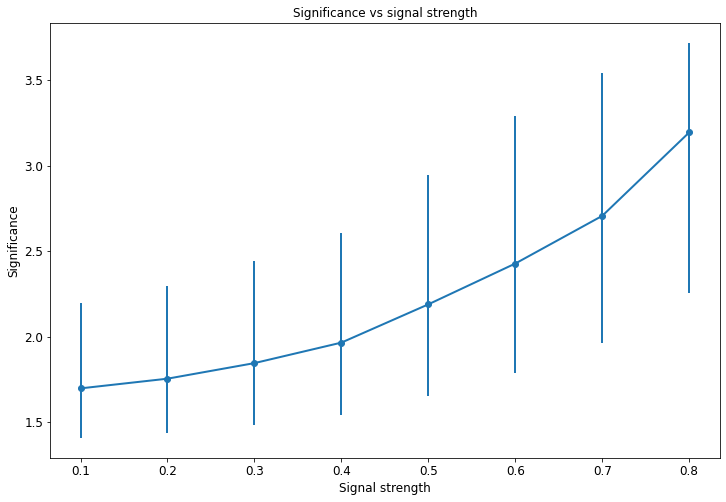

In [5]:
# Set the expected number of signal event
bh1.signal_exp = 1000

# Set the injection parameters
bh1.str_min = 0.1
bh1.str_step = 0.1
bh1.str_scale = 'lin'
bh1.sigma_limit = 3 # Injection stops when we reach 3 sigma global

# Call the injection method
bh1.signal_inject(sig_hist, bkg_hist, is_hist=True)

# Display results
bh1.plot_inject()

## 2D scan

This is the extension of the BumpHunter algorithm to 2D distributions.  
Works the same way as in 1D.

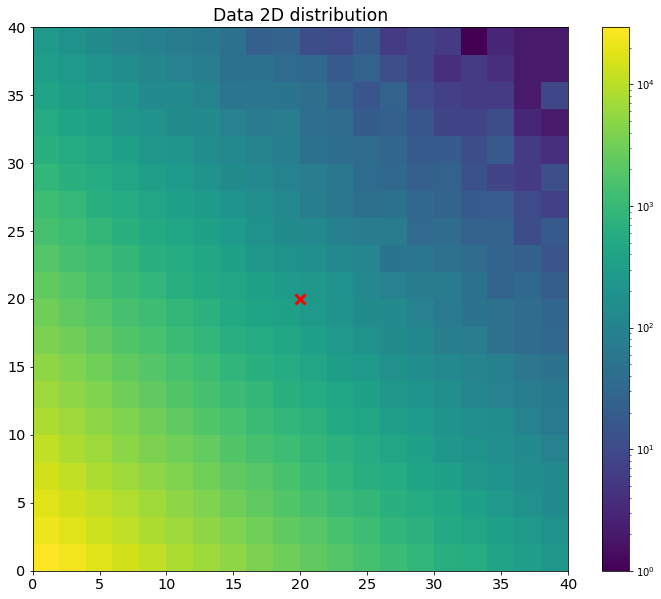

In [6]:
# Generate some background and data
np.random.seed(42)
bkg = np.random.exponential(scale=8.0, size=(600_000,2))
data = np.random.exponential(scale=8.0, size=(600_000,2))
data = np.append(
    data,
    np.random.normal(loc=20, scale=1.5, size=(200,2)),
    axis=0
)
rng = [[0,40], [0,40]]

# Make histograms
bkg_hist, binx, biny = np.histogram2d(bkg[:,0],bkg[:,1], bins=20, range=rng)
data_hist, _, _ = np.histogram2d(data[:,0], data[:,1], bins=[binx,biny])

# Plot the data distribution
F = plt.figure(figsize=(12,10))
plt.title('Data 2D distribution', size='xx-large')
plt.hist2d(data[:,0], data[:,1], bins=[binx,biny], norm=mcl.LogNorm())
plt.plot([20], [20], 'rx', ms=10, mew=3)
plt.colorbar()
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.show()

Generating histograms
4 values of width will be tested
SCAN
Global p-value : 0.0023  (14 / 6000)
Significance = 2.82919

##.print_bump_info() call##
BUMP WINDOW
   loc = [9, 9]
   width = [3, 2]
   local p-value | t = 0.00000 | 13.01777

##.print_bump_true() call##
BUMP POSITION
   min : [18.000, 18.000]
   max : [24.000, 22.000]
   mean : [21.000, 20.000]
   width : [6.000, 4.000]
   number of signal events : 172.0
   global p-value : 0.00233
   significance = 2.82919



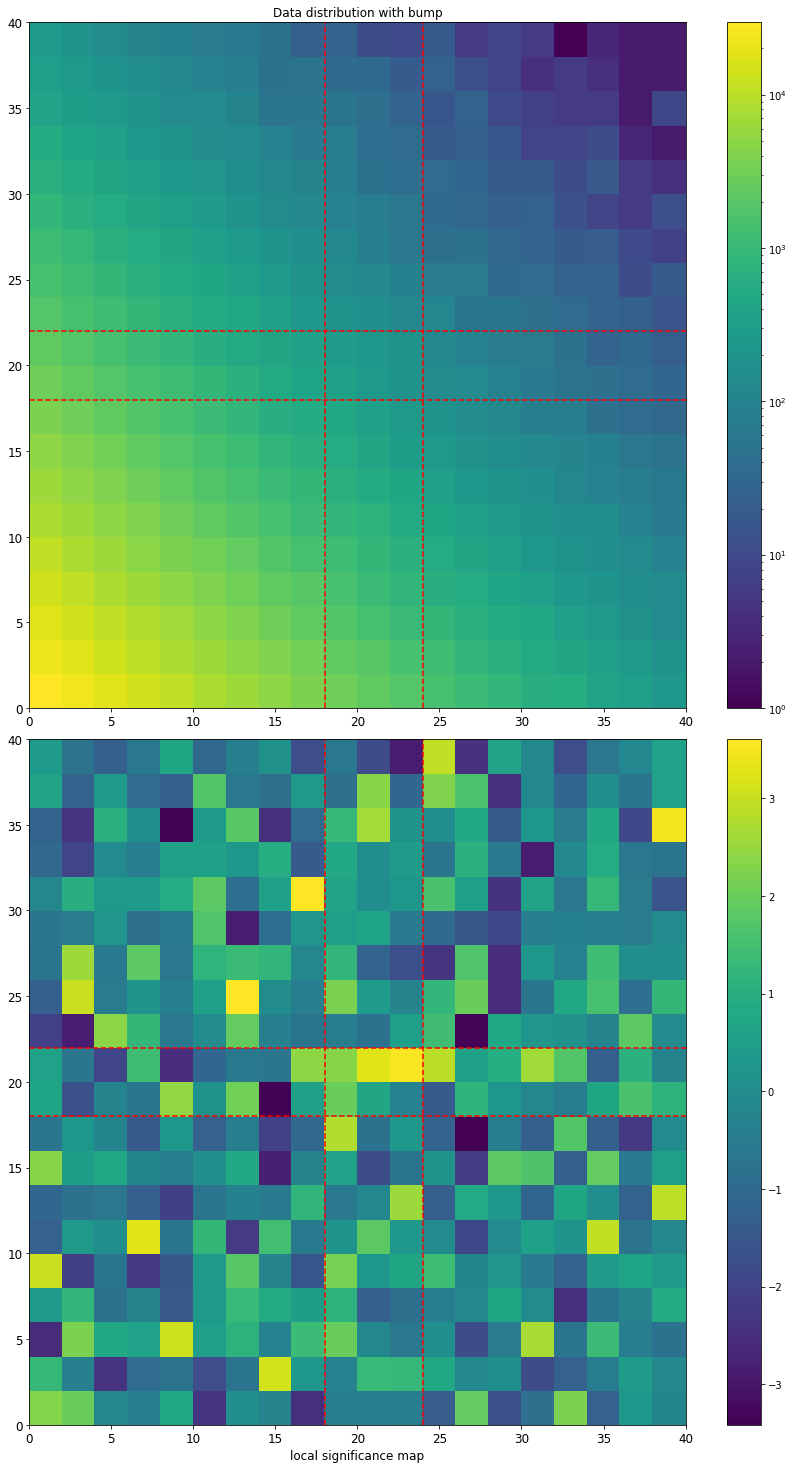

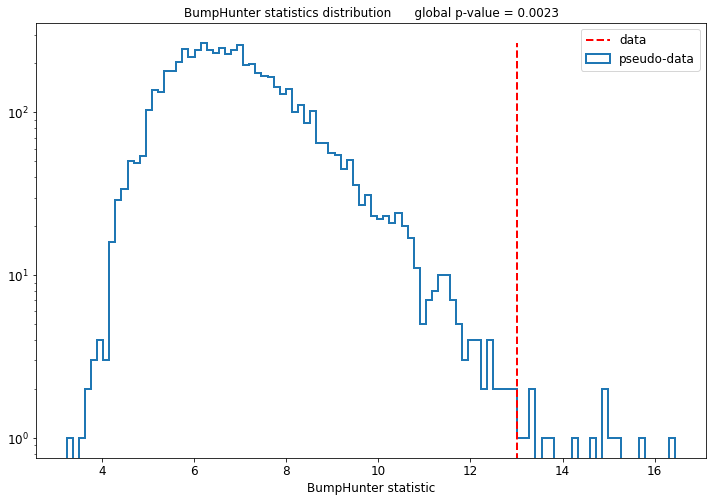

In [7]:
# Create a BumpHunter2D instance
bh2 = BH.BumpHunter2D(
    width_min=[2,2],
    width_max=[3,3],
    width_step=[1,1],
    scan_step=[1,1],
    bins=[binx,biny],
    rang=rng,
    npe=6_000,
    nworker=1,
    seed=666
)

# Call the scan method
bh2.bump_scan(data_hist, bkg_hist, is_hist=True)

# Display results
# NOTE : There is no tomography plot in 2D
print('##.print_bump_info() call##')
bh2.print_bump_info()
print('##.print_bump_true() call##')
bh2.print_bump_true(data_hist, bkg_hist, is_hist=True)

bh2.plot_bump(data_hist, bkg_hist, is_hist=True)
bh2.plot_stat(show_Pval=True)

## Side-band normalization

This option allows to correct the number of background events in the calculation of the local p-value.  
The normalization scale is computed as the data/background ratio outside of the scan window.

<img src="img/rescale.png" width="590" height="413"/>

This normalization is done automatically during the scan.  
This method can also penalize the p-value when there is a discrepancy between data and background outside of the scan window.

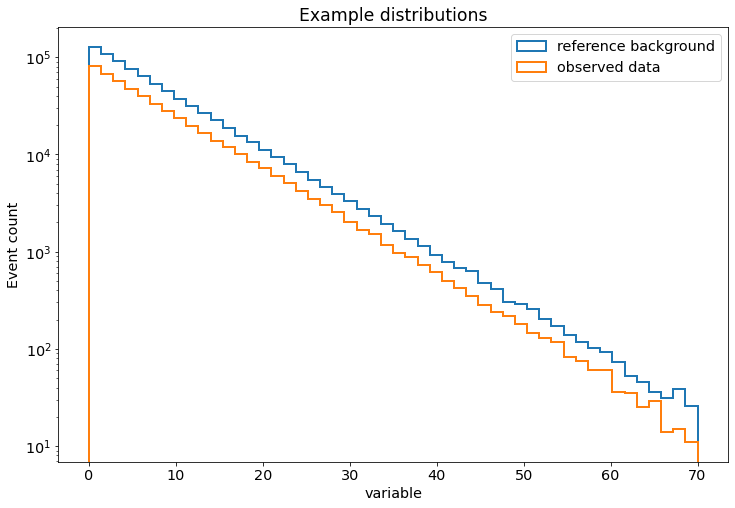

In [8]:
# Generating some background and data
np.random.seed(44)
bkg = np.random.exponential(scale=8.0, size=800_000)
data = np.random.exponential(scale=8.0, size=500_000)
data = np.append(
    data,
    np.random.normal(loc=20, scale=3, size=1200)
)
rng = [0,70]

# Make histograms
bkg_hist, bins = np.histogram(bkg, bins=50, range=rng)
data_hist, _ = np.histogram(data, bins=bins)
bkg_hist = np.array(bkg_hist, dtype=float)

# Plot the distributions
F = plt.figure(figsize=(12,8))
plt.title('Example distributions', size='xx-large')
plt.hist(bkg, bins=bins, histtype='step', lw=2, label='reference background')
plt.hist(data, bins=bins, histtype='step', lw=2, label='observed data')
plt.legend(fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.xlabel('variable',size='x-large')
plt.ylabel('Event count',size='x-large')
plt.yscale('log')
plt.show()

Generating histograms
5 values of width will be tested
SCAN
Global p-value : 0.0016  (16 / 10000)
Significance = 2.94784

##.print_bump_info() call##
BUMP WINDOW
   loc = 12
   width = 6
   local p-value | t = 0.00000 | 16.71846

##.print_bump_true() call##
BUMP POSITION
   min : 16.800
   max : 25.200
   mean : 21.000
   width : 8.400
   number of signal events : 1064.7465312775894
   global p-value : 0.00160
   significance = 2.94784



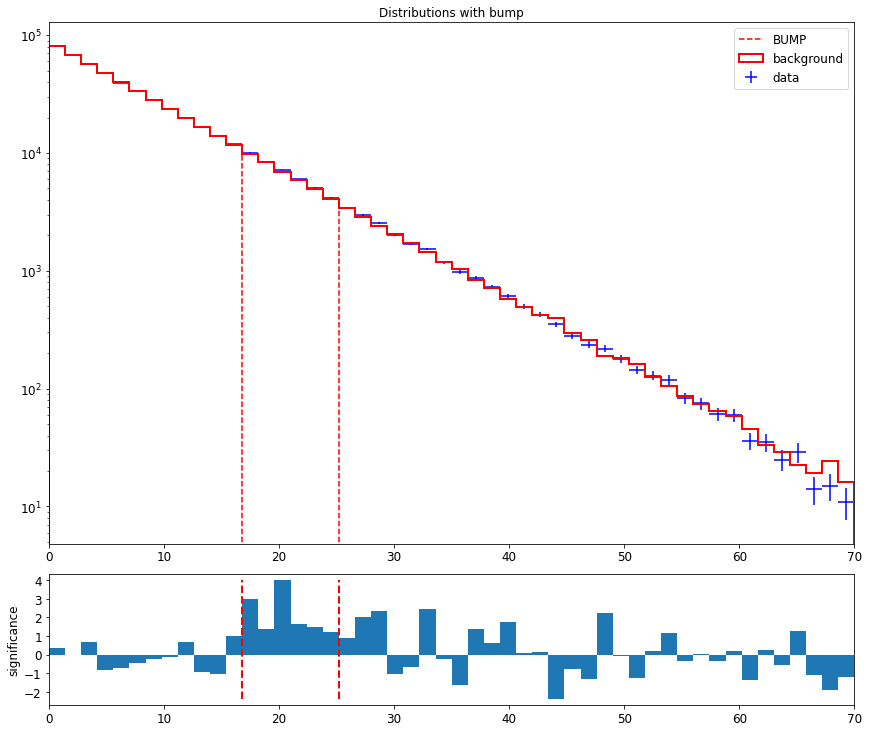

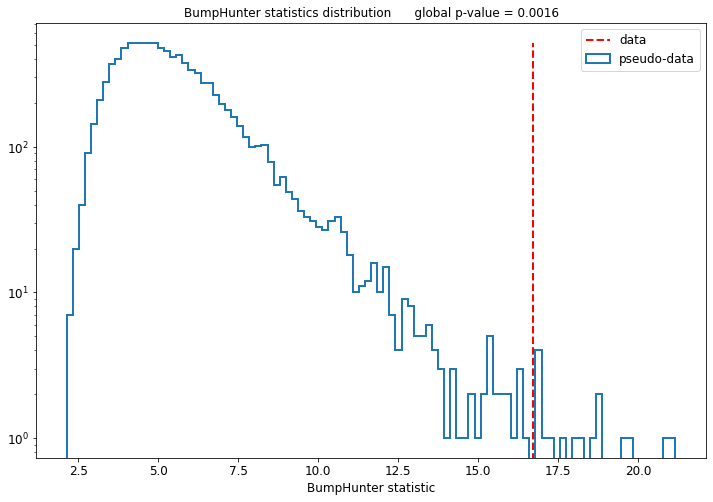

In [9]:
# Create a BumpHunter1D instance
bh1 = BH.BumpHunter1D(
    width_min=2,
    width_max=6,
    width_step=1,
    scan_step=1,
    bins=bins,
    rang=rng,
    npe=10_000,
    nworker=1,
    use_sideband=True, # Enable side-band normalization
    seed=666
)

# Call the scan method
# Here we give the data as histogramed distributions
bh1.bump_scan(data_hist, bkg_hist, is_hist=True)

# Display results
print('##.print_bump_info() call##')
bh1.print_bump_info()
print('##.print_bump_true() call##')
bh1.print_bump_true(data_hist, bkg_hist, is_hist=True)

bh1.plot_bump(data_hist, bkg_hist, is_hist=True)
bh1.plot_stat(show_Pval=True)

## Multi-channel combination (Coming soon)

This option will allow to **combine multiple channels** in order to obtain a combined global p-value and significance.  
There are two combination method :

* **multiply**  
    Applicable only if all channels have the same binning.  
    For each position and width, the combined local p-value is defined as the product of the local p-value per channel.  
    The bump window is then defined as usual.   
    <img src="img/comb_mul.png"/>

* **exclude**  
    Applicable even if all channels have different binning.  
    The combined bump window is defined as the intersection of the bump windows of each channel.  
    If there is no intersection, then the local p-value is set to 1.  
    Otherwise, the combined local p-value is the product of the local p-value per channel.  
    <img src="img/comb_exc.png"/>

## Plan and future development

### For the next release

* Add multi-channel combination

### Major additions planned

* API refactoring, with a DataHandler class that manages the histograming part separately

* Add possibility to treat systematic uncertainties

* Other features that might be interesting (***your* ideas are welcome!**)

A paper presenting all the new features in detail is in preparation.